# *Step 1 - Gathering data & Preprocessing the Data*



In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import ccxt
import pandas as pd
from datetime import datetime


binance = ccxt.binance()

symbol = "BTC/USDT"
timeframe = "5m"
start_date = '2020-01-01T00:00:00Z'
since = binance.parse8601(start_date)

data = []
while since < binance.milliseconds():
    ohlcv = binance.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=1000)
    if len(ohlcv) == 0:
        break
    data += ohlcv
    since = ohlcv[-1][0] + 1 

df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df = df[['timestamp', 'close']]

df


,timestamp,close
0,2020-01-01 00:00:00,7179.78
1,2020-01-01 00:05:00,7191.07
2,2020-01-01 00:10:00,7180.97
3,2020-01-01 00:15:00,7178.29
4,2020-01-01 00:20:00,7176.96
...,...,...
509003,2024-11-03 23:45:00,68896.00
509004,2024-11-03 23:50:00,68832.86
509005,2024-11-03 23:55:00,68775.99
509006,2024-11-04 00:00:00,68678.07


In [ ]:
# Inspecting

In [10]:
df.head()

,timestamp,close
0,2020-01-01 00:00:00,7179.78
1,2020-01-01 00:05:00,7191.07
2,2020-01-01 00:10:00,7180.97
3,2020-01-01 00:15:00,7178.29
4,2020-01-01 00:20:00,7176.96


In [11]:
df.tail()

,timestamp,close
509003,2024-11-03 23:45:00,68896.00
509004,2024-11-03 23:50:00,68832.86
509005,2024-11-03 23:55:00,68775.99
509006,2024-11-04 00:00:00,68678.07
509007,2024-11-04 00:05:00,68600.00


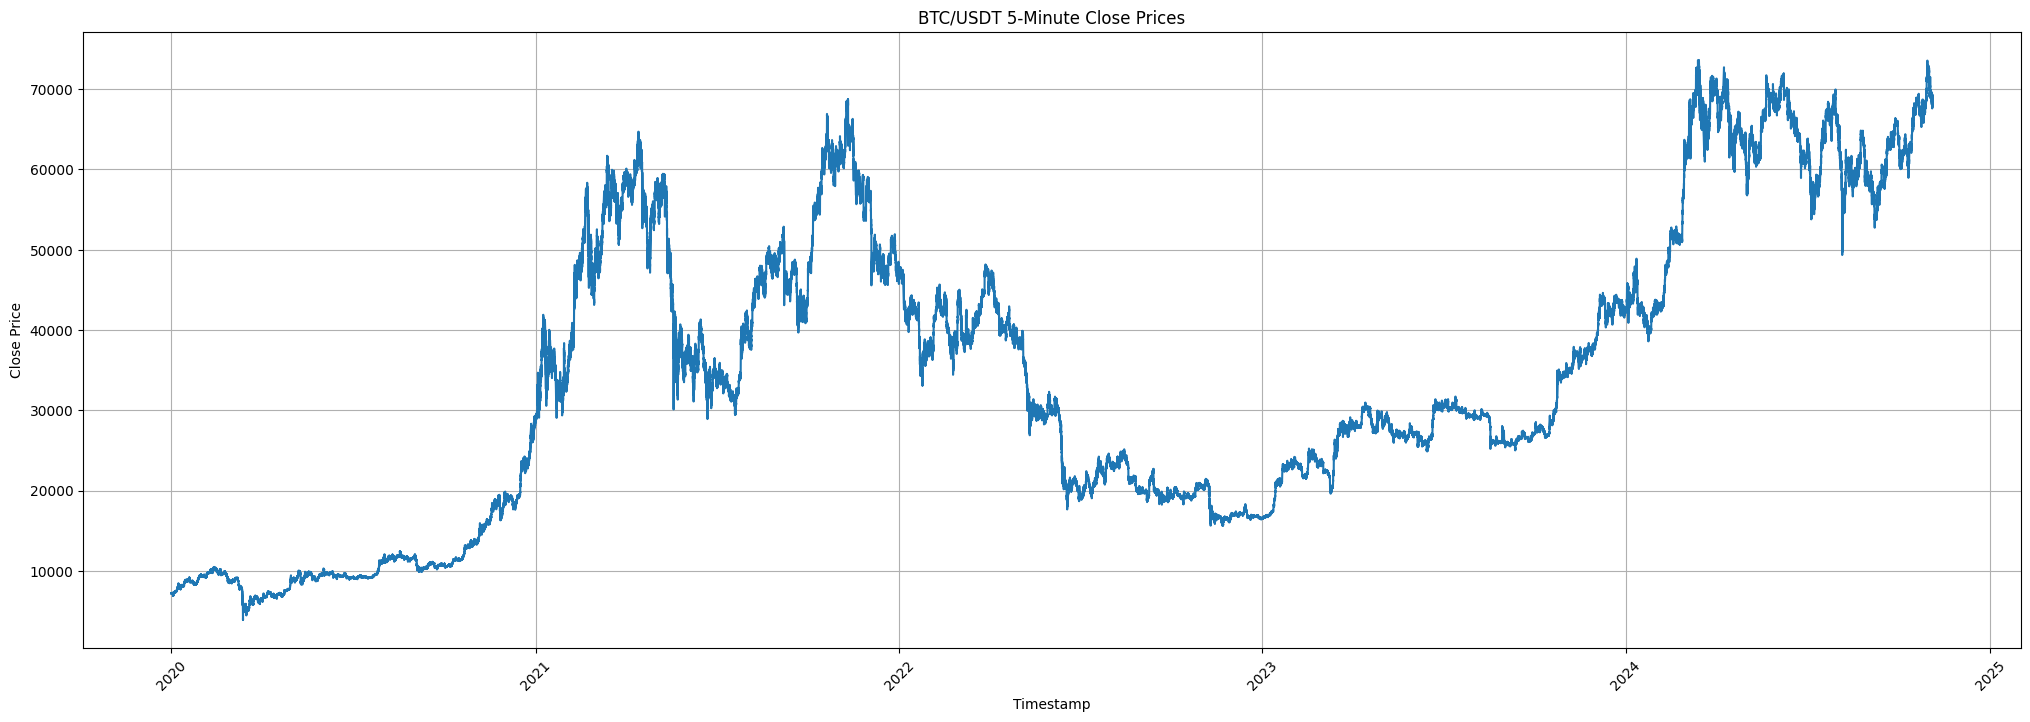

In [27]:
plt.figure(figsize=(25,8))
plt.plot(df['timestamp'] , df['close'])
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('BTC/USDT 5-Minute Close Prices')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [29]:
df["log_rtn"] = df["close"].apply(np.log).diff(1)

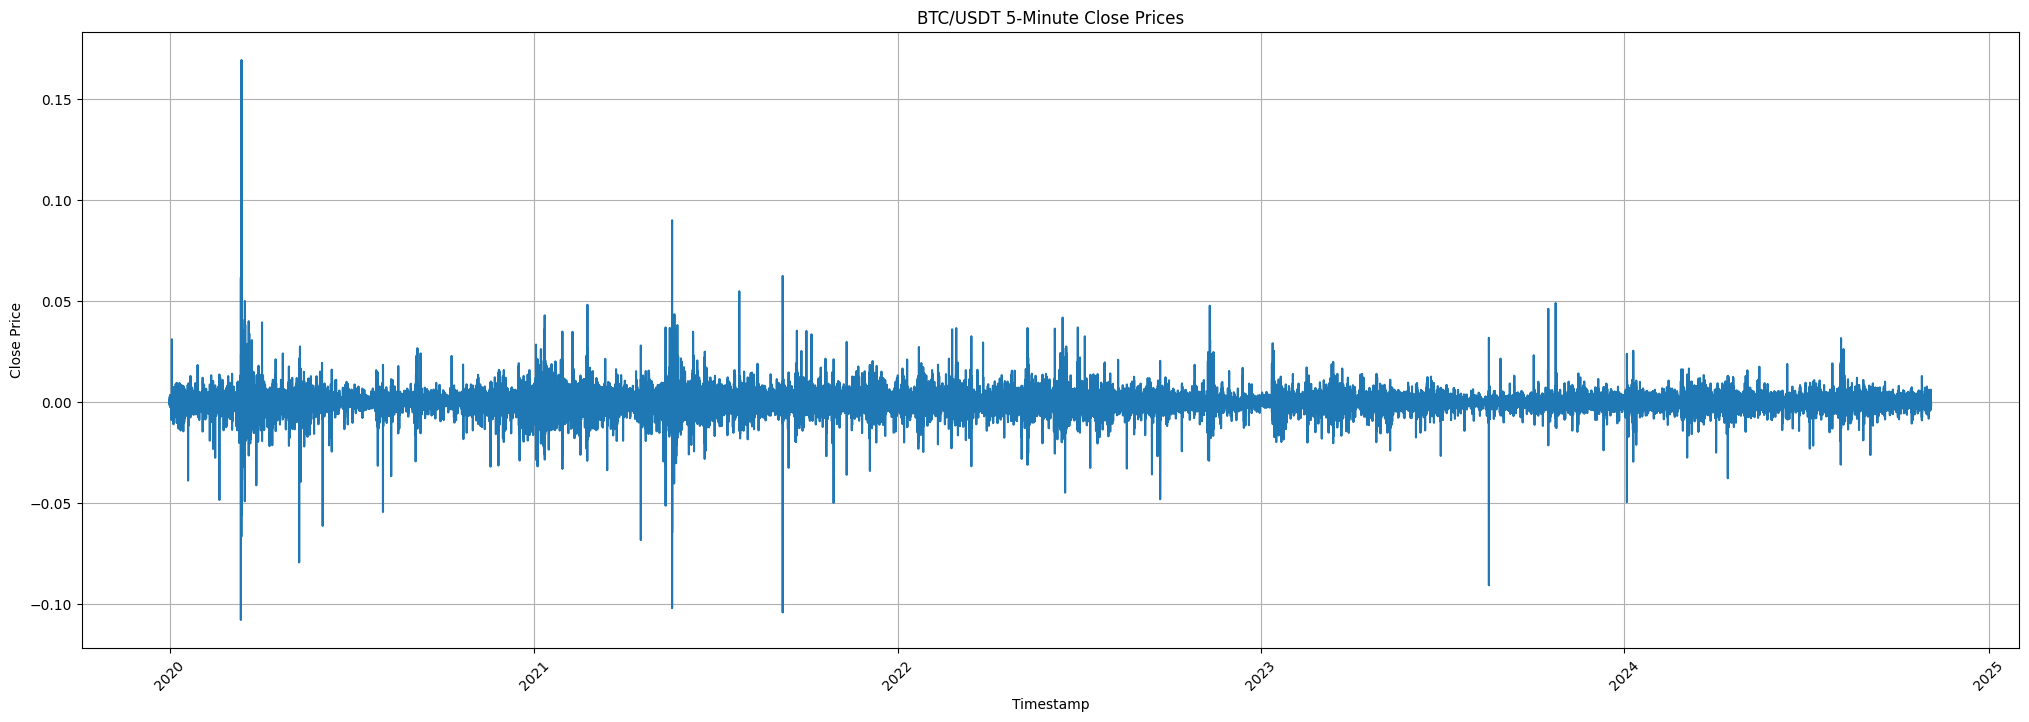

In [30]:
plt.figure(figsize=(25,8))
plt.plot(df['timestamp'] , df['log_rtn'])
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('BTC/USDT 5-Minute Close Prices')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [161]:
df["sma"] = df["close"].rolling(window=288).mean() 

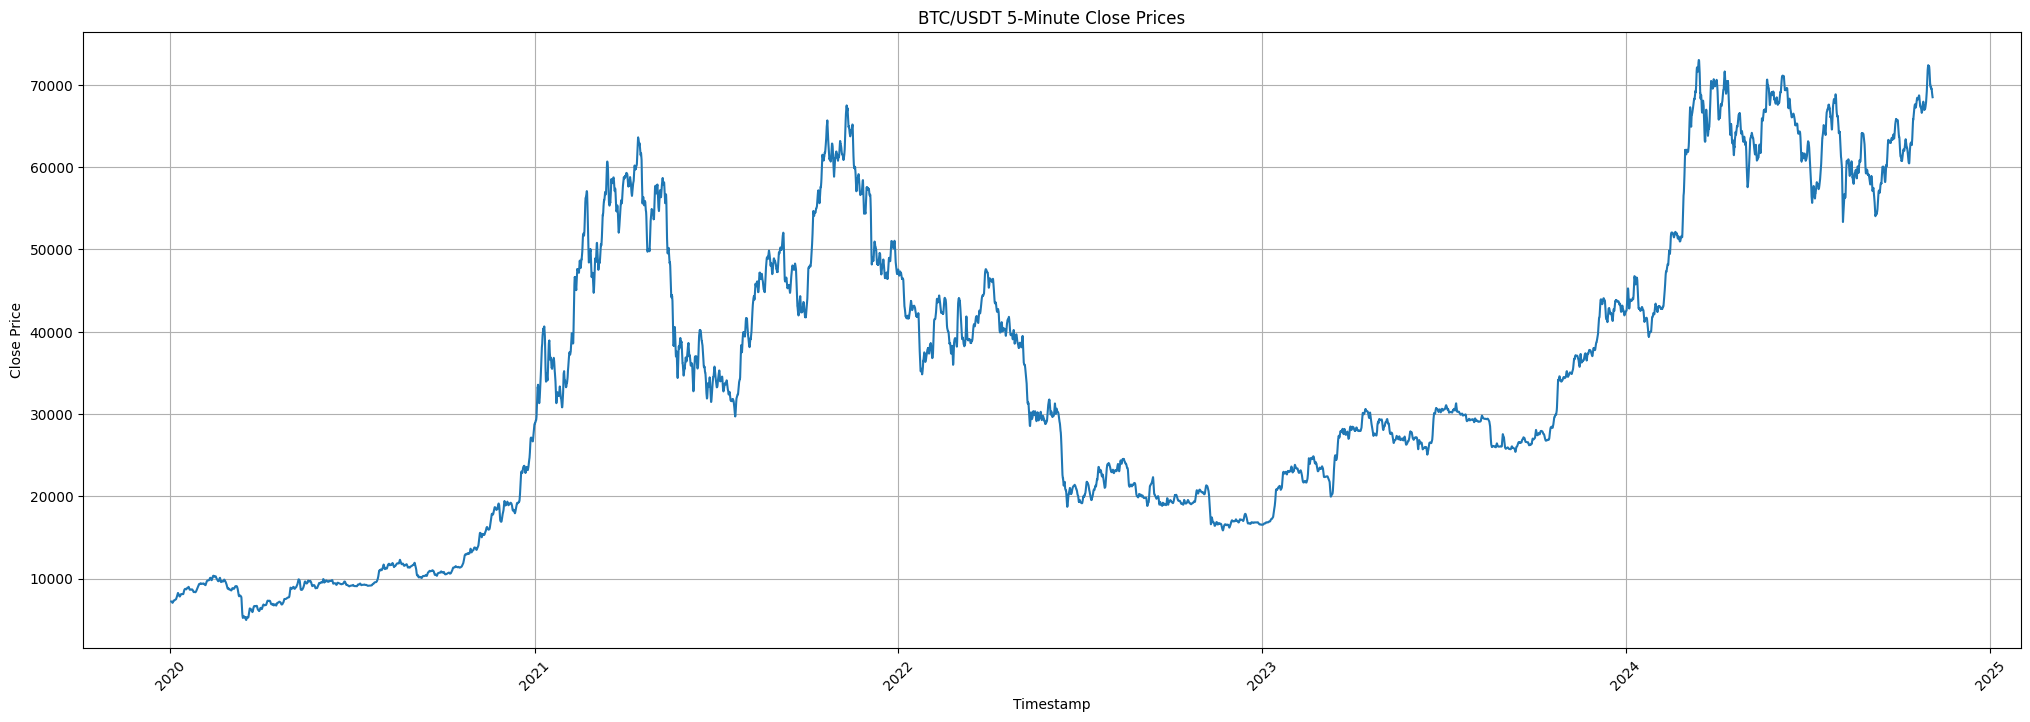

In [162]:
plt.figure(figsize=(25,8))
plt.plot(df['timestamp'] , df["sma"])
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('BTC/USDT 5-Minute Close Prices')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# *Step 2 - Defining and applying the strategy rules to the data*


In [163]:
# frist strategy generates only buy signal if price crossing simple MA with specified MA window parameter

df["position"] = (df["close"] > df["sma"]).astype(int)


In [164]:
# counting how many times long position was entered
sum((df["position"] == 1) & (df["position"].shift(1) == 0))

8259

# *Step 3 - Vectorized Backtesting* 

- vectorized backtesting with pandas
- event driven backtesting with backtrader
- backtesting a moving avarage crossover strategy using crypto data
- 

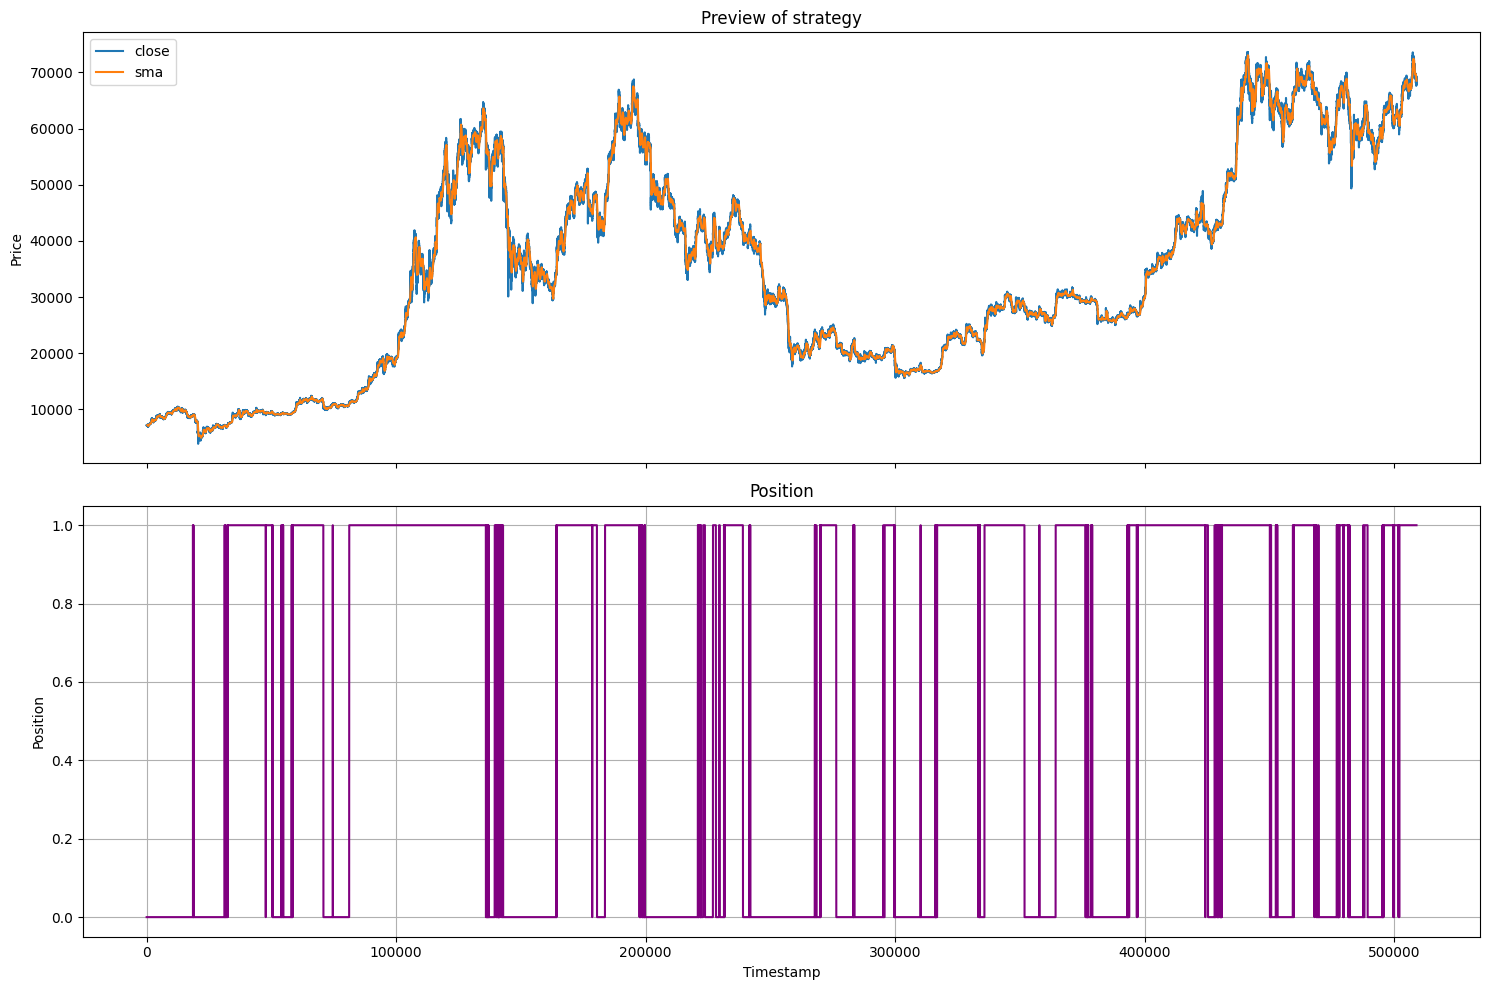

In [173]:
fig, ax = plt.subplots(2, figsize=(15, 10), sharex=True)


df[['close', "sma"]].plot(ax=ax[0])
ax[0].set_title("Preview of strategy")
ax[0].set_ylabel("Price")

df['position'].plot(ax=ax[1], color='purple')
ax[1].set_title("Position")
ax[1].set_ylabel("Position")

plt.xlabel("Timestamp")
plt.grid(True)
plt.tight_layout()
plt.show()

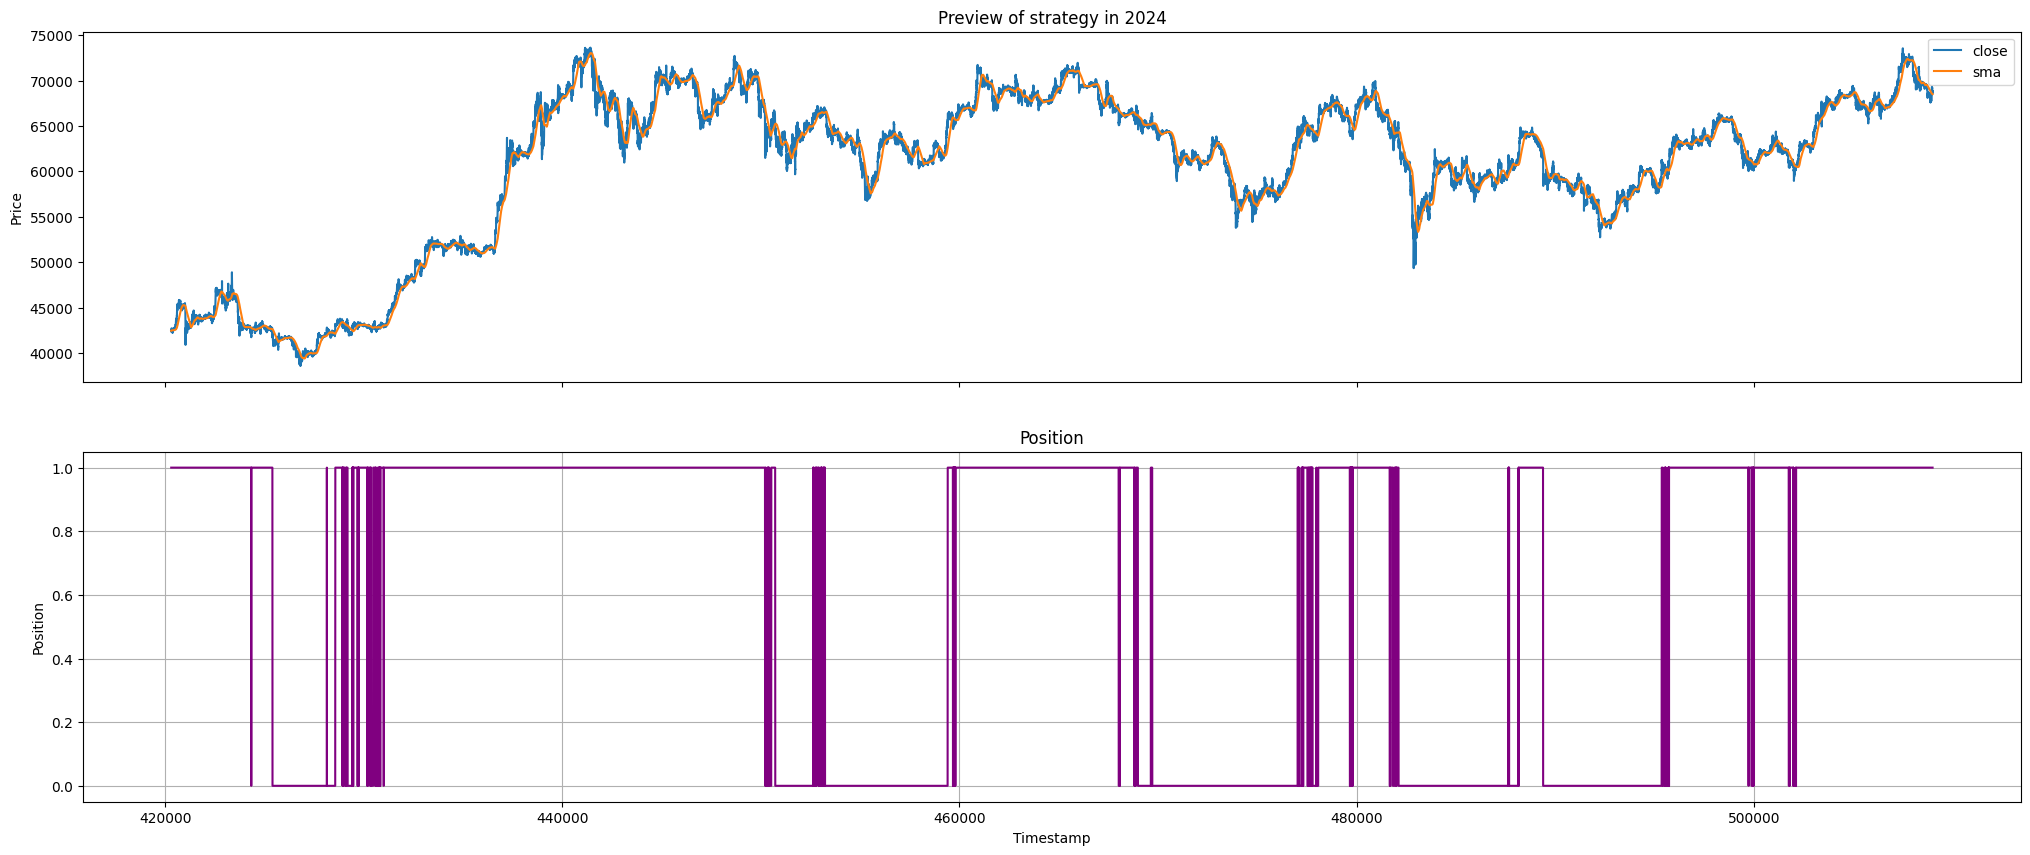

In [188]:
# zoomin in only for preview..
df_2024 = df[df['timestamp'].dt.year == 2024]

fig, ax = plt.subplots(2, figsize=(25, 10), sharex=True)

df_2024[['close', 'sma']].plot(ax=ax[0])
ax[0].set_title("Preview of strategy in 2024")
ax[0].set_ylabel("Price")


df_2024['position'].plot(ax=ax[1], color='purple')
ax[1].set_title("Position")
ax[1].set_ylabel("Position")

plt.xlabel("Timestamp")
plt.grid(True)
plt.show()

# *Step 4 -  Evaluation of strategy performance*

In [167]:
#calculating strategy performance over whole dataset (close prices)


In [168]:
df["strategy_rtn"] = df["position"].shift(1) * df["log_rtn"]
df["strategy_rtn_cum"] = ( df["strategy_rtn"].cumsum().apply(np.exp) )

In [169]:
# buy and hodl for comparison/ as benchmark!!!
££
df["bh_rtn_cum"] = df["log_rtn"].cumsum().apply(np.exp)

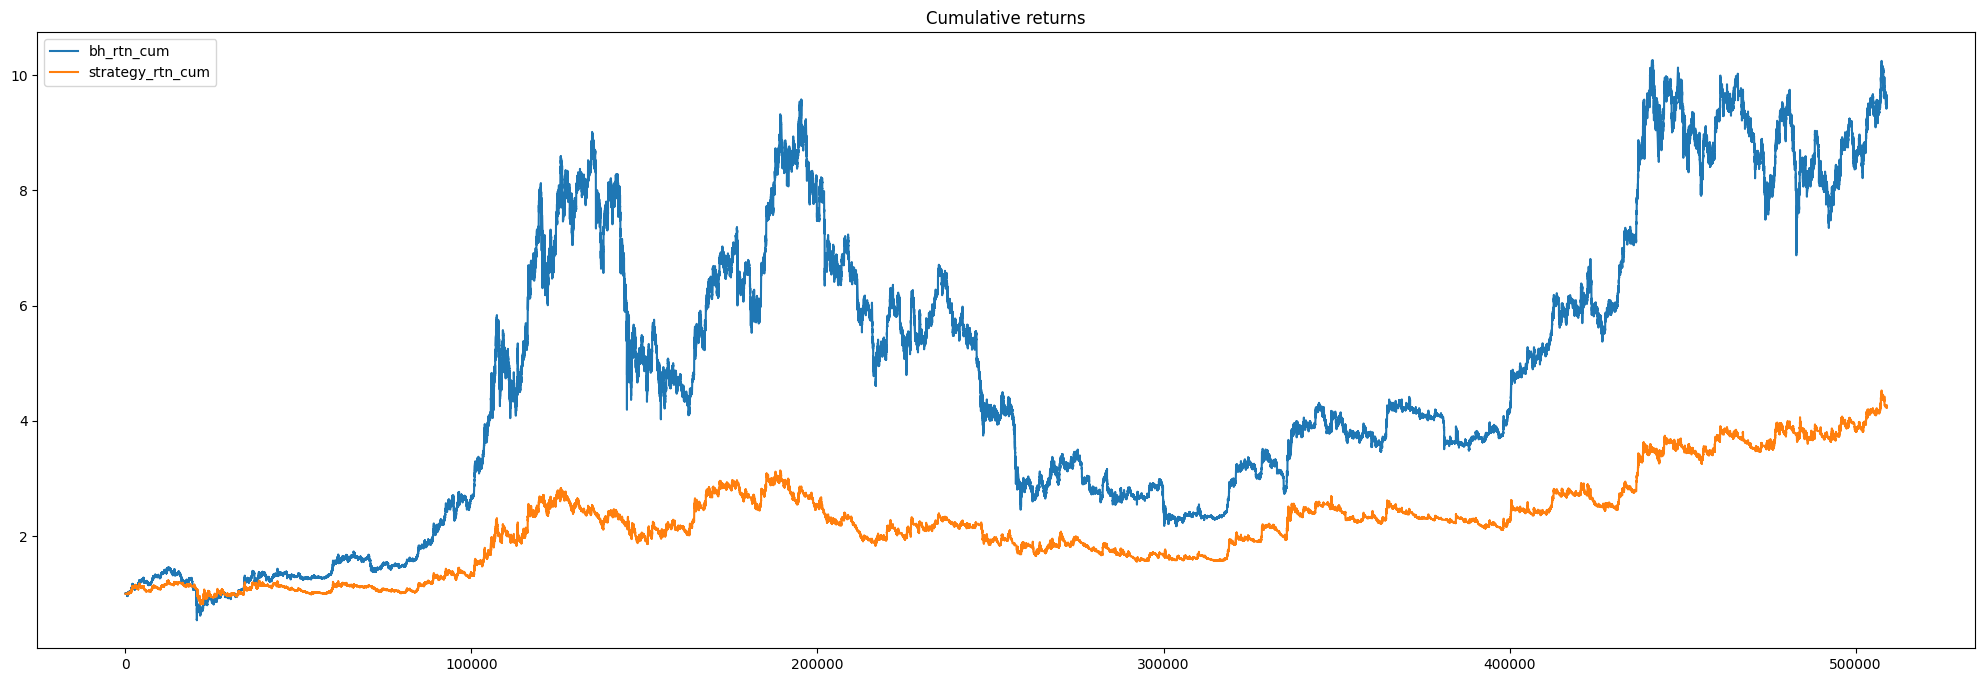

In [170]:
df[["bh_rtn_cum", "strategy_rtn_cum"]].plot(title="Cumulative returns", figsize=(25, 8))
plt.show()


# :((((

In [171]:
# Searching for the optimal SMA window that maximizes the returns of the strategy vs the bh_rtn_cum ( as benchmark ).

best_sma = 0
max_superior_return = -np.inf


sma_range = range(20, 50001, 1)  

for sma in sma_range:
    
    df["sma_test"] = df["close"].rolling(window=sma).mean()
    df["position"] = (df["close"] > df["sma_test"]).astype(int)

    
    df["strategy_rtn"] = df["position"].shift(1) * df["log_rtn"]
    df["strategy_rtn_cum"] = df["strategy_rtn"].cumsum().apply(np.exp)

    superior_return = df["strategy_rtn_cum"].iloc[-1] - df["bh_rtn_cum"].iloc[-1]
    
    # Checkin if this SMA gives a better result than previously found
    if superior_return > max_superior_return:
        max_superior_return = superior_return
        best_sma = sma


print(f"The best SMA window is: {best_sma}")
print(f"The maximum superior return over benchmark: {max_superior_return}")


df["sma_best"] = df["close"].rolling(window=best_sma).mean()
df["position"] = (df["close"] > df["sma_best"]).astype(int)
df["strategy_rtn"] = df["position"].shift(1) * df["log_rtn"]
df["strategy_rtn_cum"] = df["strategy_rtn"].cumsum().apply(np.exp)

The best SMA window is: 16463
The maximum superior return over benchmark: 8.837153028029146


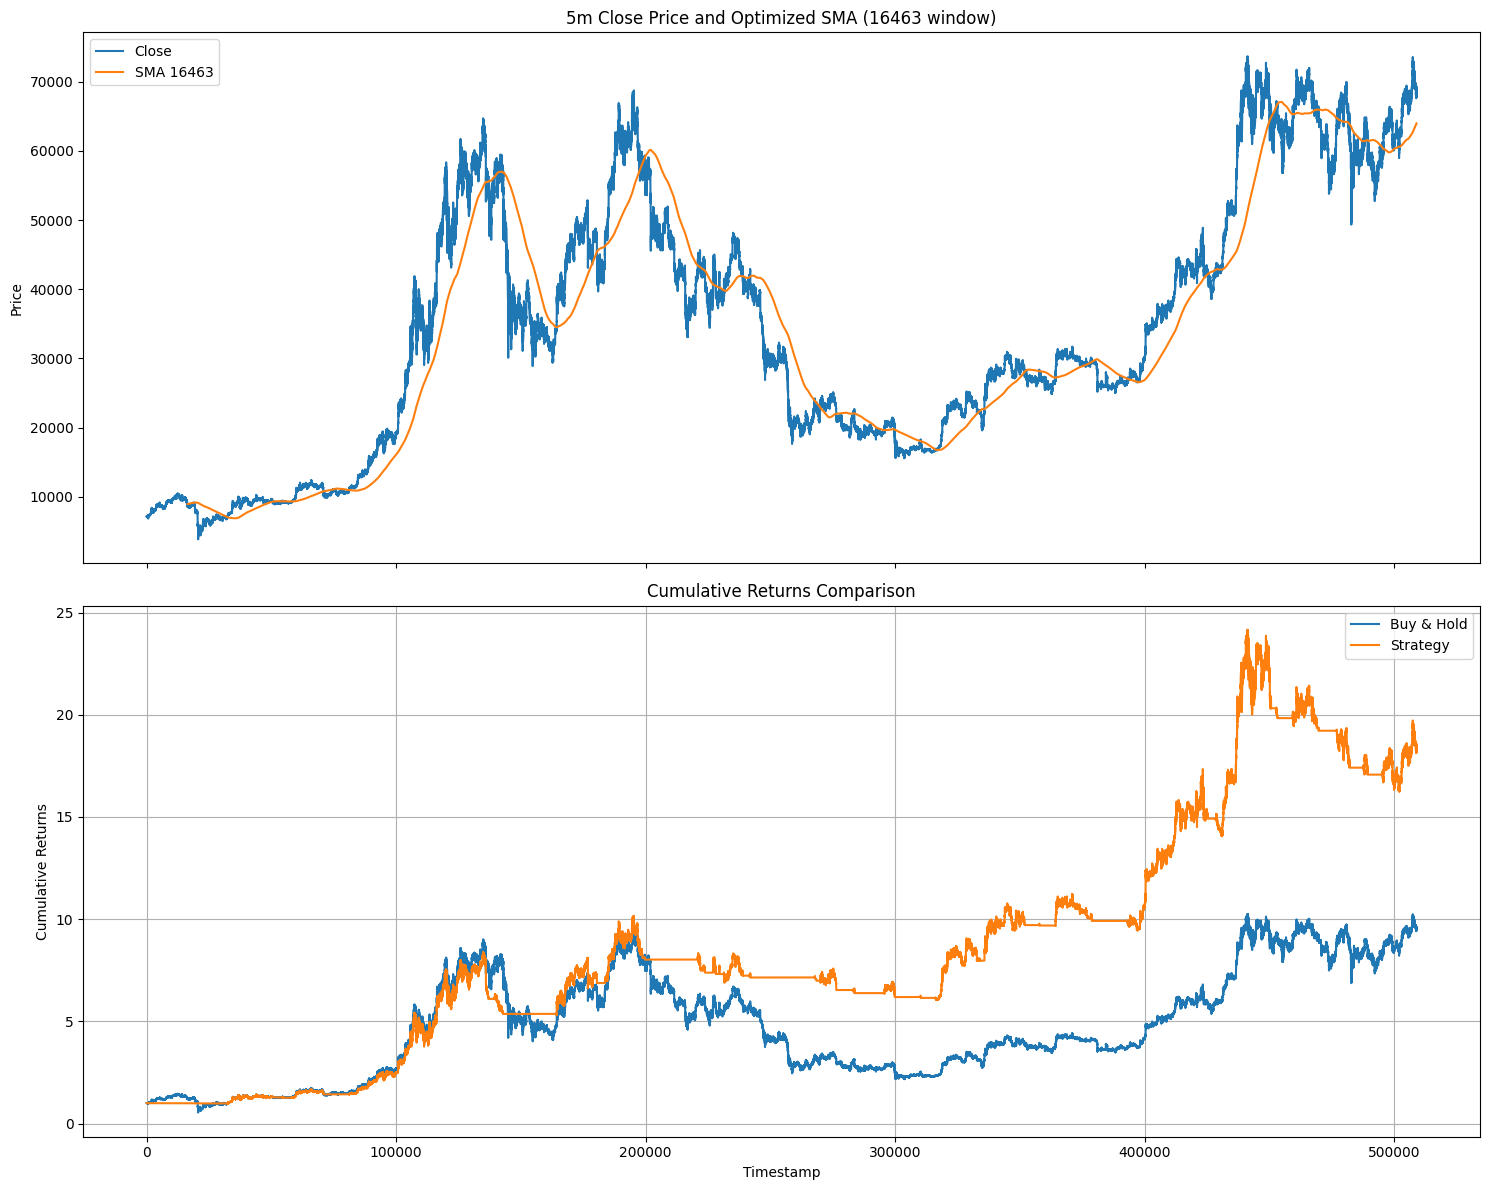

In [172]:

fig, ax = plt.subplots(2, figsize=(15, 12), sharex=True)

df[['close', 'sma_best']].plot(ax=ax[0])
ax[0].set_title(f"5m Close Price and Optimized SMA ({best_sma} window)")
ax[0].set_ylabel("Price")
ax[0].legend(["Close", f"SMA {best_sma}"])

df[["bh_rtn_cum", "strategy_rtn_cum"]].plot(ax=ax[1])
ax[1].set_title("Cumulative Returns Comparison")
ax[1].set_ylabel("Cumulative Returns")
ax[1].legend(["Buy & Hold", "Strategy"])

plt.xlabel("Timestamp")
plt.grid(True)
plt.tight_layout()
plt.show()


----

## *Event driven backtesting with backtrader*

####  Rules :

- buying with 70 % of cash when fast MA crosses slow MA
- selling when price crosses 20 SMA (not shorting)


In [195]:
#reusing data from previous experiment , and ingesting it into BT framework
df = df[['timestamp', 'close']]
df.to_csv('btc_data.csv', index=False)

from datetime import datetime
import backtrader as bt


In [225]:
pd.read_csv("btc_data.csv")

,timestamp,close
0,2020-01-01 00:00:00,7179.78
1,2020-01-01 00:05:00,7191.07
2,2020-01-01 00:10:00,7180.97
3,2020-01-01 00:15:00,7178.29
4,2020-01-01 00:20:00,7176.96
...,...,...
509003,2024-11-03 23:45:00,68896.00
509004,2024-11-03 23:50:00,68832.86
509005,2024-11-03 23:55:00,68775.99
509006,2024-11-04 00:00:00,68678.07


In [215]:
data = bt.feeds.YahooFinanceCSVData(dataname='btc_data.csv')
cerebro.adddata(data)

In [216]:
# commision scheme allowing for fractional trades

class FractionalTradesCommission(bt.CommissionInfo):
    def getsize(self, price, cash):
        """Returns the fractional size"""
        return self.p.leverage * (cash / price)

In [209]:
# defining sma crossover strategy

In [218]:
class SMACrossoverStrategy(bt.Strategy):
    params = (
        ("ma_fast" , 288),
        ("ma_slow" , 1440), 
        ("target_perc", 0.7)
)

In [226]:
def __init__(self):

    self.data_close = self.datas[0].close

    self.order = None

    #calc the sma crossover signal
    self.fast_ma = bt.indicators.MovingAvarageSimple(self.datas[0], period=self.params.ma_fast)

    self.slow_ma = bt.indicators.MovingAvarageSimple(self.datas[0], period=self.params.ma_slow)

    self.ma_crossover = bt.indicators.CrossOver(self.fast_ma , self.slow_ma)

def log(self, txt):
    #code

In [236]:
def next(self):
    if self.order:
        # pending order execution. Waiting in orderbook
        return

    if not self.position:
        # buy order
        if self.ma_crossover > 0:
            self.order = self.order_target_percent(target=self.params.target_perc)
            log_str = get_action_log_string("b", "c", price=self.data_close[0], size=self.order.size, cash=self.broker.getcash(), open=self.data_open[0], close=self.data_close[0])
            self.log(log_str)

        elif self.ma_crossover < 0:
            # sell order
            log_str = get_action_log_string("s", "c", self.data_close[0], self.position.size)
            self.log(log_str)
            self.order = self.order_target_percent(target=0)

def notify_order(self, order):
    
    pass

def notify_trade(self, trade):
    
    pass

def next(self):
    
    pass

def start(self):
    print(f"Initial portfolio value: {self.broker.get_value():.2f}")

def stop(self):
    print(f"Final portfolio value: {self.broker.get_value():.2f}")



In [238]:


class MyBuySell(bt.Observer):
    lines = ('buy', 'sell')

    def next(self):
        # Logic for the observer, marking buy and sell points on the chart
        if self._owner.buy_signal:
            self.lines.buy[0] = self._owner.data.close[0]
        elif self._owner.sell_signal:
            self.lines.sell[0] = self._owner.data.close[0]


In [229]:
# seting up the backtest

In [243]:
cerebro = bt.Cerebro(stdstats=False)

cerebro.addstrategy(SMACrossoverStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.addcommissioninfo(FractionalTradesCommission(commission=0.001))  # Added closing parenthesis
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="time_return")




In [246]:
import backtrader as bt
import pandas as pd

# Load your data and set the timestamp as the index
data = pd.read_csv('btc_data.csv', parse_dates=['timestamp'])
data.set_index('timestamp', inplace=True)

# Define a custom Pandas DataFeed
class CustomData(bt.feeds.PandasData):
    # Only include 'close' in the lines since we don't have other columns
    lines = ('close',)

    # Specify the mapping of data columns to Backtrader
    params = (
        ('datetime', None),   # Use the DataFrame index as the datetime
        ('close', 'close'),   # Column for close prices
        ('open', None),       # No open prices
        ('high', None),       # No high prices
        ('low', None),        # No low prices
        ('volume', None),     # No volume
        ('openinterest', None),  # No open interest
    )

# Instantiate Cerebro
cerebro = bt.Cerebro(stdstats=False)

# Add your strategy (assuming SMACrossoverStrategy is defined elsewhere)
cerebro.addstrategy(SMACrossoverStrategy)

# Add data to Cerebro
data_feed = CustomData(dataname=data)
cerebro.adddata(data_feed)

# Configure broker and other parameters
cerebro.broker.setcash(10000.0)
cerebro.broker.addcommissioninfo(FractionalTradesCommission(commission=0.001))
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="time_return")

# Run backtest
backtest_result = cerebro.run()



In [248]:
cerebro.plot(iplot=True , volume=False)

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 2 Axes>]]

In [ ]:
£